# 📚 PCA 실습 과제 — MNIST + CIFAR-10


본 과제는 수업 시간에 다룬 **PCA 실습 자료**를 확장한 버전입니다.  
과제에서 해결해야하는 부분은 <font color=green>**주석처리**</font>와 함께 `???`로 표기했으니 빈칸 부분을 채워 주시면 됩니다.

### 과제 목표
- 이번 과제에서는 저번 과제에서 사용하였던 MNIST dataset에 더해 좀 더 어려운 데이터셋인 CIFAR10이라는 데이터셋을 사용해볼 예정. CIFAR-10 dataset은 아래의 링크에서 자세한 설명을 확인할 수 있음:

[https://www.cs.toronto.edu/~kriz/cifar.html](https://www.cs.toronto.edu/~kriz/cifar.html)

- 간단한 설명을 하자면 이 데이터셋은 50,000개의 학습 이미지와 10,000개의 테스트 이미지로 구성이 되어 있음. 그리고 데이터셋은 총 10개의 범주 (class)로 이루어진 데이터셋임.

![CIFAR-10 dataset example](https://docs.pytorch.org/tutorials/_images/cifar10.png)

- 우리는 이 MNIST와 CIFAR10 dataset을 이용하여 PCA를 진행하고 PCA를 통해 가볍게 저장한 데이터가 원래 데이터를 얼마나 복원할 수 있는지를 확인하는 과제를 진행할 예정

### 필수 라이브러리/함수
- `StandardScaler`: `fit_transform`, `inverse_transform`
- `PCA`: `fit`, `fit_transform`, `transform`, `inverse_transform`, `explained_variance_ratio_`
- `numpy`: `np.cumsum`, `np.argmax`, `np.random.choice`, `np.random.randn`
- `matplotlib.pyplot`: `plt.imshow`, `plt.scatter`, `plt.plot`


## 0) 환경 설정

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torchvision
from torchvision import datasets, transforms
plt.rcParams['figure.dpi'] = 120
np.random.seed(42)
print('Ready')

Ready



## 1) 데이터 로딩 → 벡터화 → 10k 서브샘플
### 먼저 데이터셋 50,000장을 한꺼번에 PCA에 이용하면 계산량의 축소를 위해 10,000장의 데이터셋만 사용할 예정.
### 또한, CIFAR 10 이미지는 MNIST dataset과는 달리 RGB 값으로 이루어진 color image이기 때문에 간단한 PCA 진행을 위해 gray scale로 단순화 하여 통일할 예정.
### - MNIST의 경우는 image의 size가 28x28이므로 <font color=blue>**784**</font>차원의 데이터이며 gray scale로 바꾼 CIFAR-10의 경우 image의 size가 32*32이므로 <font color=blue>**1024**</font>차원의 데이터.
### - 우리는 이중에서 적은 수의 dimension만으로 데이터 정보의 대부분을 저장할 수 있는 것을 목표로 하려고 함.
### - 이미지를 불러오고 샘플하여 전처리하는 과정은 pytorch Package를 이용하며 아래와 같은 함수들을 이용함.

- MNIST: `datasets.MNIST`, `transforms.ToTensor()`
- CIFAR-10: 미리보기용 `transforms.ToTensor()`(RGB), PCA용 `transforms.Grayscale(num_output_channels=1)`+`transforms.ToTensor()`
- 벡터화: `view(B, -1)` 또는 `reshape(B, -1)`
- 서브샘플: `np.random.choice(..., size=10000, replace=False)`


In [20]:
mnist = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
X_mnist_full = mnist.data.numpy().astype(np.float32).reshape(len(mnist), -1)
y_mnist_full = mnist.targets.numpy()
idx_m = np.random.choice(len(X_mnist_full), size=10000, replace=False)
X_mnist = X_mnist_full[idx_m]
y_mnist = y_mnist_full[idx_m]
img_h_m, img_w_m = 28, 28
print('MNIST 10k:', X_mnist.shape)

cifar_rgb = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar_gray = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()]))
Xc_list, yc_list = [], []
for img, label in torch.utils.data.DataLoader(cifar_gray, batch_size=256, shuffle=False):
    Xc_list.append(img.view(img.size(0), -1).numpy())  # [B, 1024]
    yc_list.append(np.array(label))
X_cifar_full = np.concatenate(Xc_list, axis=0).astype(np.float32)
y_cifar_full = np.concatenate(yc_list, axis=0)
idx_c = np.random.choice(len(X_cifar_full), size=10000, replace=False)
X_cifar = X_cifar_full[idx_c]
y_cifar = y_cifar_full[idx_c]
img_h_c, img_w_c = 32, 32
print('CIFAR-10 10k (gray):', X_cifar.shape)

cifar10_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

MNIST 10k: (10000, 784)
CIFAR-10 10k (gray): (10000, 1024)



## 1-1) 데이터 시각화
###- 과제에 사용할 데이터를 시각화함.
###- CIFAR-10데이터셋은 원래 RGB값을 가지는 데이터셋이지만 PCA 적용을 위해 gray scale의 이미지로 변환하여 사용.

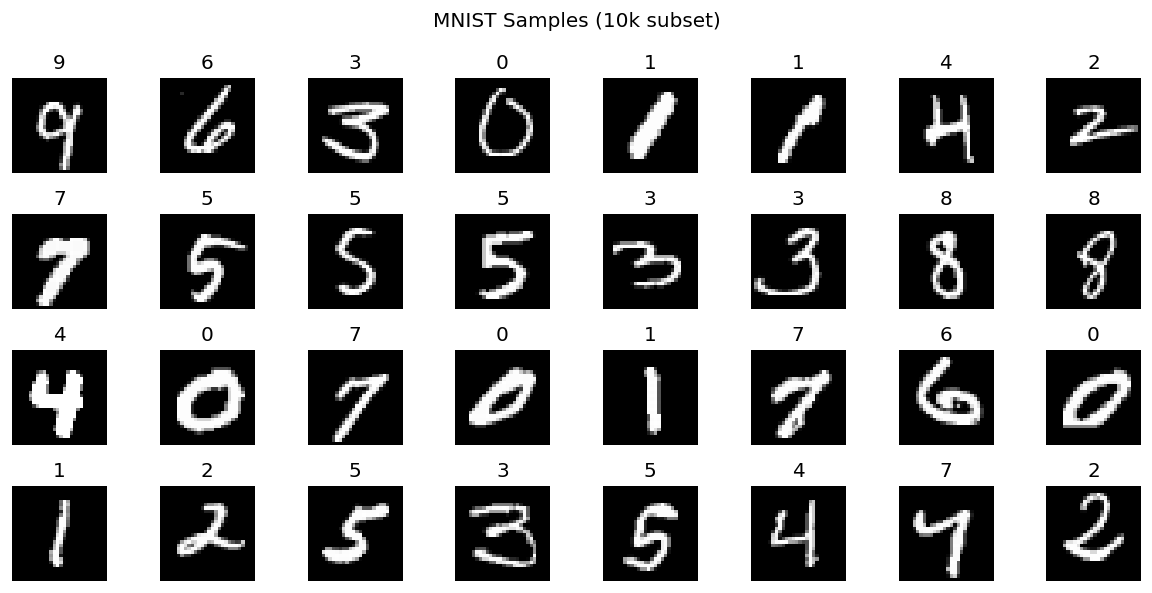

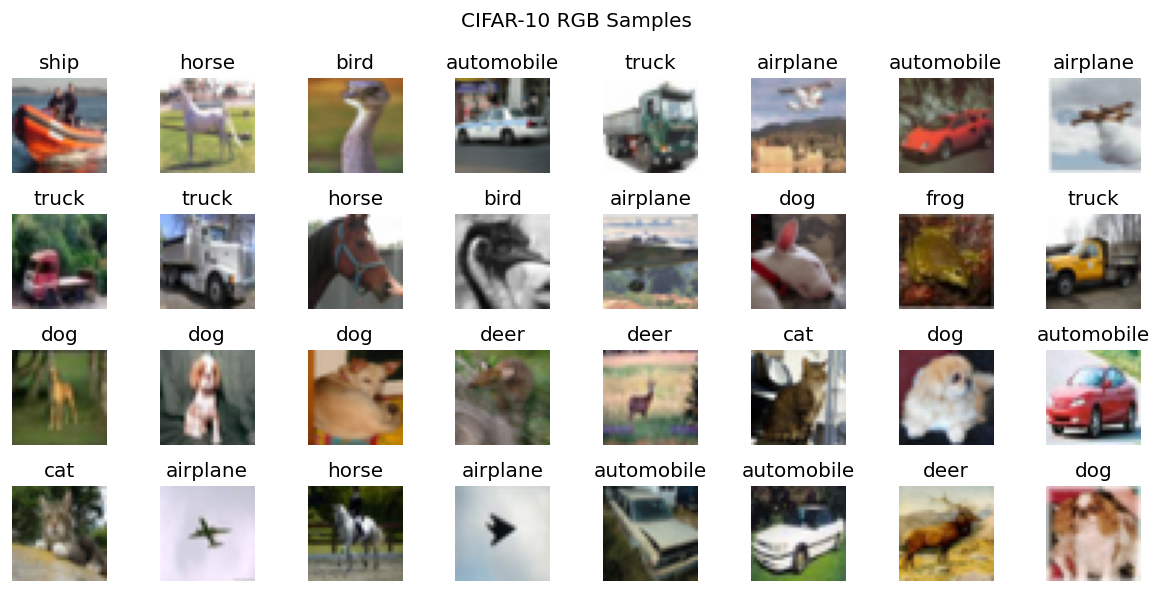

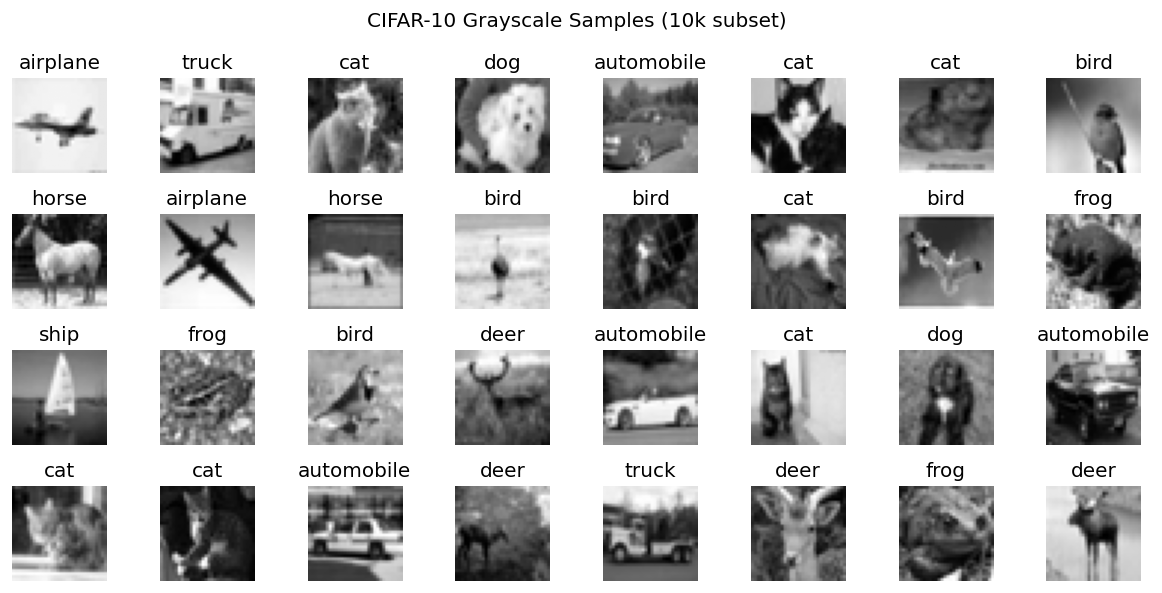

In [21]:
fig, axes = plt.subplots(4, 8, figsize=(10,5))
idxs_prev = np.random.choice(len(X_mnist), size=32, replace=False)
for ax, i in zip(axes.ravel(), idxs_prev):
    ax.imshow(X_mnist[i].reshape(img_h_m, img_w_m), cmap='gray')
    ax.set_title(int(y_mnist[i]))
    ax.axis('off')
plt.suptitle('MNIST Samples (10k subset)'); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(4, 8, figsize=(10,5))
idxs_prev_rgb = np.random.choice(len(cifar_rgb), size=32, replace=False)
for ax, i in zip(axes.ravel(), idxs_prev_rgb):
    ax.imshow(cifar_rgb.data[i])
    ax.set_title(f"{cifar10_names[int(cifar_rgb.targets[i])]}")
    ax.axis('off')
plt.suptitle('CIFAR-10 RGB Samples'); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(4, 8, figsize=(10,5))
idxs_prev_g = np.random.choice(len(X_cifar), size=32, replace=False)
for ax, i in zip(axes.ravel(), idxs_prev_g):
    ax.imshow(X_cifar[i].reshape(img_h_c, img_w_c), cmap='gray')
    ax.set_title(f"{cifar10_names[int(y_cifar[i])]}")
    ax.axis('off')
plt.suptitle('CIFAR-10 Grayscale Samples (10k subset)'); plt.tight_layout(); plt.show()

## 2) <font color=red>**(문제1; 10점)**</font> 표준화(Standardization or Normalization)
###- 주어진 데이터를 그대로 사용하여 분산을 계산할 때만 normalization 혹은 standardization을 해줘도 되지만 간편한 계산을 위해 각 데이터셋마다 평균 0, 분산 1이 되도록 변환을 해줌.
###- 변환에 사용하는 함수는 **scikit learn** package의 `StandardScaler`
###- MNIST dataset을 표준화 하는데 사용된 scaler_m과 scaler_m.fit_transform과 유사하게 cifar10 dataset을 표준화 하는 scaler_c를 선언하고 이를 이용하여 CIFAR10 dataset을 표준화하시오.


In [22]:
scaler_m = StandardScaler()  # mnist dataset을 위한 StandardScaler 선언
X_mnist_scaled = scaler_m.fit_transform(X_mnist)  # scaler_m을 이용하여 mnist dataset을 표준화
# scaler_c = ???  # mnist dataset과 마찬가지로 CIFAR-10 dataset을 위한 StandardScaler 선언
# X_cifar_scaled = scaler_c.fit_transform(???)  # scaler_c를 이용하여 cifar-10 dataset을 표준화
scaler_c = StandardScaler()
X_cifar_scaled = scaler_c.fit_transform(X_cifar)
print('Scaled:', X_mnist_scaled.shape, X_cifar_scaled.shape)

Scaled: (10000, 784) (10000, 1024)



## 3) <font color='red'>(문제2; 20점)</font>Principle Component의 개수 k(95%) 계산
### - 데이터의 variance의 95% 이상이 되도록 하는 principle component의 개수 k의 최소값을 MNIST와 CIFAR10 dataset에 대해서 각각 구하시오.
### - 먼저 위에서 scale된 X_minst_scaled와 X_cifar_scaled를 이용하여 PCA모델을 각각 학습시킴.
### - <font color=blue>np.cumsum()</font>함수는 주어진 numpy array값을 앞에서부터 순서대로 더해주는 함수. np.cumsum()을 이용하여 각 principle component까지 순차적으로 더했을 때 variance의 총 몇 퍼센트까지 cover했는지 계산.
### - 그 뒤 <font color=blue>np.argmax()</font>함수를 이용하여 cumsum이 처음으로 0.95이상이 되는 지점 찾기.

In [23]:
# MNIST
# pca_m = PCA().fit(???)  # X_mnist_scaled를 이용하여 학습
# cumsum_m = np.cumsum(???)  # 학습된 pca를 이용하여 cover된 variance의 비율을 계산
# k95_m = int(np.argmax(???) + 1)  # np.argmax를 통해 처음으로 비율이 0.95이상이 되는 지점 파악
pca_m = PCA().fit(X_mnist_scaled)
cumsum_m = np.cumsum(pca_m.explained_variance_ratio_)
k95_m = int(np.argmax(cumsum_m >= 0.95) + 1)
print('MNIST k(95%):', k95_m)

# CIFAR-10
# pca_c = PCA().fit(???)  # X_cifar_scaled를 이용하여 학습
# cumsum_c = np.cumsum(???)  # 학습된 pca를 이용하여 cover된 variance의 비율을 계산
# k95_c = int(np.argmax(???) + 1)  # TODO
pca_c = PCA().fit(X_cifar_scaled)
cumsum_c = np.cumsum(pca_c.explained_variance_ratio_)
k95_c = int(np.argmax(cumsum_c >= 0.95) + 1)
print('CIFAR-10 k(95%):', k95_c)

MNIST k(95%): 292
CIFAR-10 k(95%): 159


## 3-b) Cumulative Variance Plot과 Explained Variance Ratio plot 그리기
### - Plot을 통해 점점 각각의 component가 설명하는 variance의 크기가 줄어드는 것을 확인할 수 있고 적은 수의 component만으로 95%에 해당하는 데이터 정보를 저장할 수 있는 것을 확인 가능.


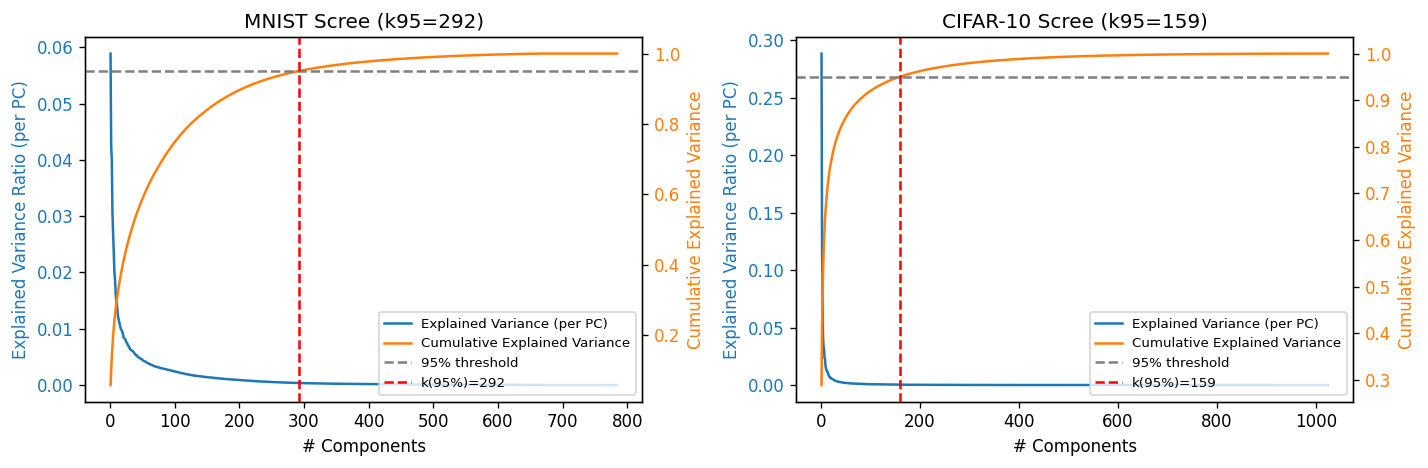

In [24]:
def plot_scree(ax, evr, cumsum, k95, title):
    ax.plot(np.arange(1, len(evr)+1), evr, color='tab:blue', label='Explained Variance (per PC)')
    ax.set_xlabel('# Components')
    ax.set_ylabel('Explained Variance Ratio (per PC)', color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax.twinx()
    ax2.plot(np.arange(1, len(cumsum)+1), cumsum, color='tab:orange', label='Cumulative Explained Variance')
    ax2.set_ylabel('Cumulative Explained Variance', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    ax2.axhline(0.95, linestyle='--', color='gray', label='95% threshold')
    ax2.axvline(k95, linestyle='--', color='red', label=f'k(95%)={k95}')

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower right', fontsize=8)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_scree(axes[0], pca_m.explained_variance_ratio_, cumsum_m, k95_m, f'MNIST Scree (k95={k95_m})')
plot_scree(axes[1], pca_c.explained_variance_ratio_, cumsum_c, k95_c, f'CIFAR-10 Scree (k95={k95_c})')
plt.tight_layout(); plt.show()


## 4)<font color=red>(문제3; 10점)</font> 2D 투영
- PCA에서 가장 많은 variance를 설명하는 두 개의 축에 데이터를 사용하여 각 데이터들이 2차원 공간에 어떻게 분포되는지 확인
- component를 2개만 가지는 PCA모델 선언 후 주어진 데이터들을 이용한 학습을 통해 variance를 가장 많이 설명하는 2개의 축 추출


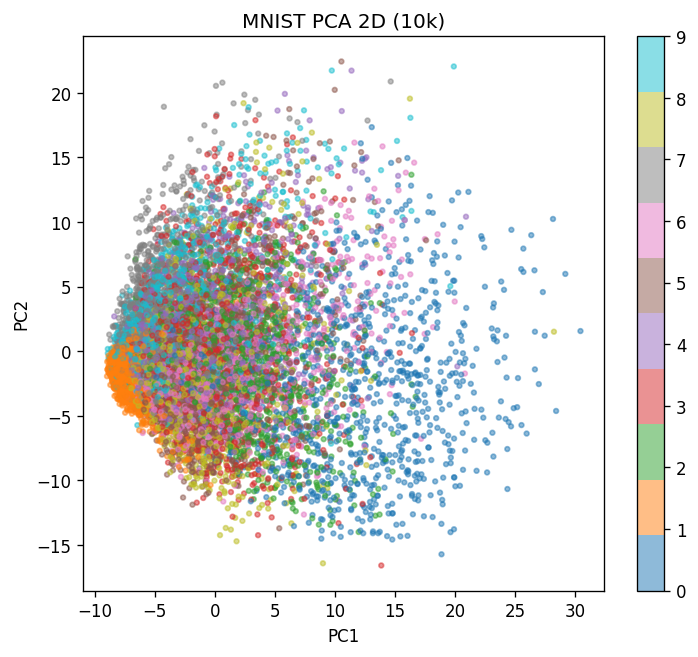

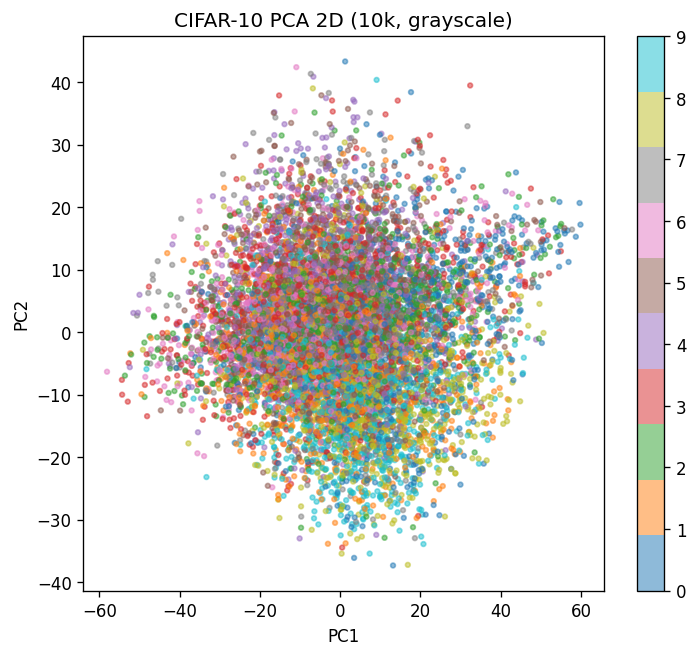

In [25]:
# MNIST 2D
# pca2_m = PCA(n_components=???) ## principle component의 개수 입력
# X_mnist_2d = pca2_m.fit_transform(???) # mnist 학습데이터 입력
pca2_m = PCA(n_components=2)
X_mnist_2d = pca2_m.fit_transform(X_mnist_scaled)
plt.figure(figsize=(7,6))
scm = plt.scatter(X_mnist_2d[:,0], X_mnist_2d[:,1], c=y_mnist, cmap='tab10', alpha=0.5, s=8)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('MNIST PCA 2D (10k)')
plt.colorbar(scm); plt.show()

# CIFAR-10 2D
# pca2_c = PCA(n_components=???) ## principle component의 개수 입력
# X_cifar_2d = pca2_c.fit_transform(???) # cifar 학습데이터 입력
pca2_c = PCA(n_components=2)
X_cifar_2d = pca2_c.fit_transform(X_cifar_scaled)
plt.figure(figsize=(7,6))
scc = plt.scatter(X_cifar_2d[:,0], X_cifar_2d[:,1], c=y_cifar, cmap='tab10', alpha=0.5, s=8)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('CIFAR-10 PCA 2D (10k, grayscale)')
plt.colorbar(scc); plt.show()


## 3-b 클래스 부분집합 2D 시각화 (각 3세트)
### - 모든 class에 대해 전체를 한꺼번에 plot하면 겹침이 커서 구별이 어려움.
### - 데이터들이 어떻게 분포가 되는지 보기 위해 **둘/셋 클래스만** 골라 비교함.
### - <font color=red>2개의 차원</font>만 가지고는 다양한 데이터들을 구별하여 <font color=red>충분한 중요 정보들을 담기에는 부족</font>하다는 것을 확인 가능.
### - 데이터를 가볍하게 하되 적절한 양의 정보를 담을 수 있을 만큼 압축하는 것이 중요.


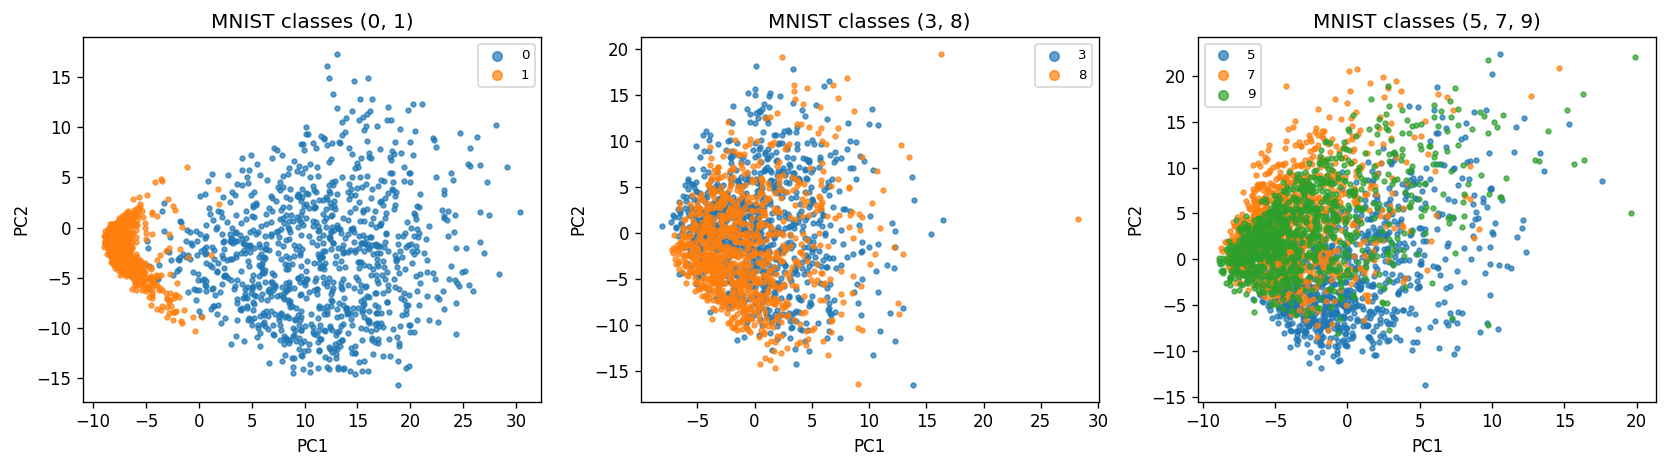

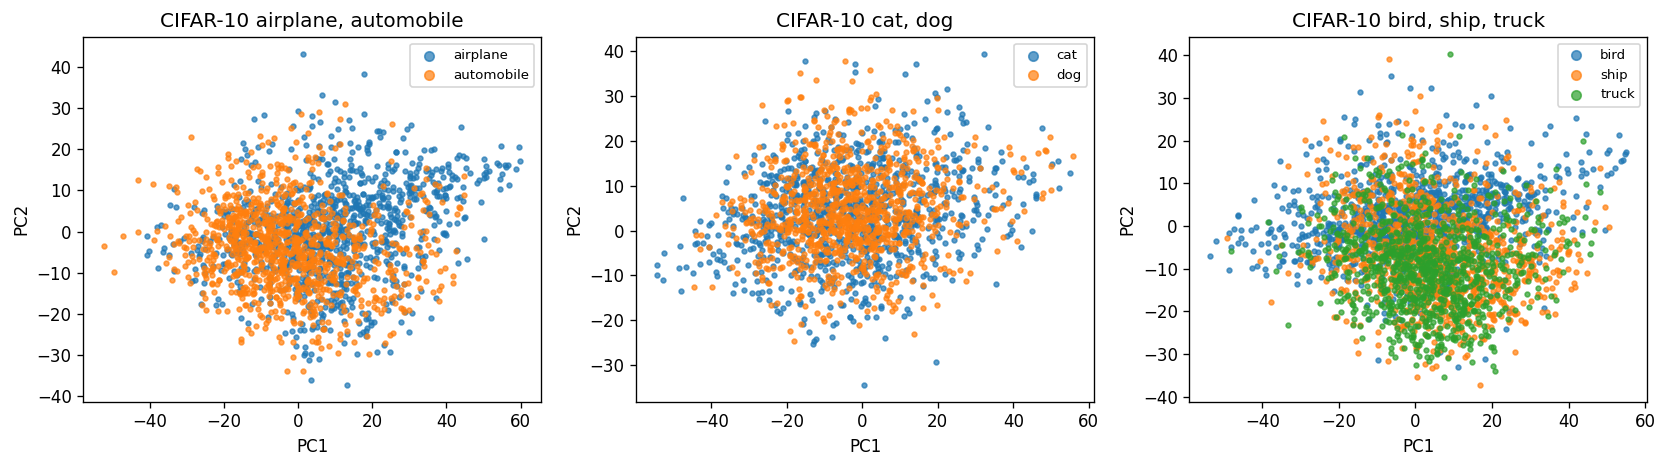

In [26]:
def plot_subset(ax, X2d, y, class_ids, name_map=None, title=''):
    for cid in class_ids:
        m = (y == cid)
        lbl = name_map[cid] if name_map is not None else str(cid)
        ax.scatter(X2d[m,0], X2d[m,1], s=8, alpha=0.7, label=lbl)
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_title(title)
    ax.legend(markerscale=2, fontsize=8)

mnist_sets = [(0,1), (3,8), (5,7,9)]
fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, s in zip(axes, mnist_sets):
    plot_subset(ax, X_mnist_2d, y_mnist, s, None, title=f'MNIST classes {s}')
plt.tight_layout(); plt.show()

cifar_sets = [(0,1), (3,5), (2,8,9)]  # airplane/automobile, cat/dog, bird/ship/truck
fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, s in zip(axes, cifar_sets):
    plot_subset(ax, X_cifar_2d, y_cifar, s, cifar10_names, title='CIFAR-10 ' + ', '.join([cifar10_names[i] for i in s]))
plt.tight_layout(); plt.show()


## 4-b) PCA 복원 이미지 plot
###- `inverse_transform`을 사용하여 pca를 통해 압축된 이미지가 어떻게 변하는지 확인.
###- 각각의 image들은 정보의 양을 95퍼센트만큼 복원할 수 있는 최소의 principle component만을 사용하여 복원했을 때의 결과임.
###- <font color=blue>높은 압축률에도 불구하고 이미지의 대부분의 정보를 복원하는 것을 확인할 수 있음.</font>


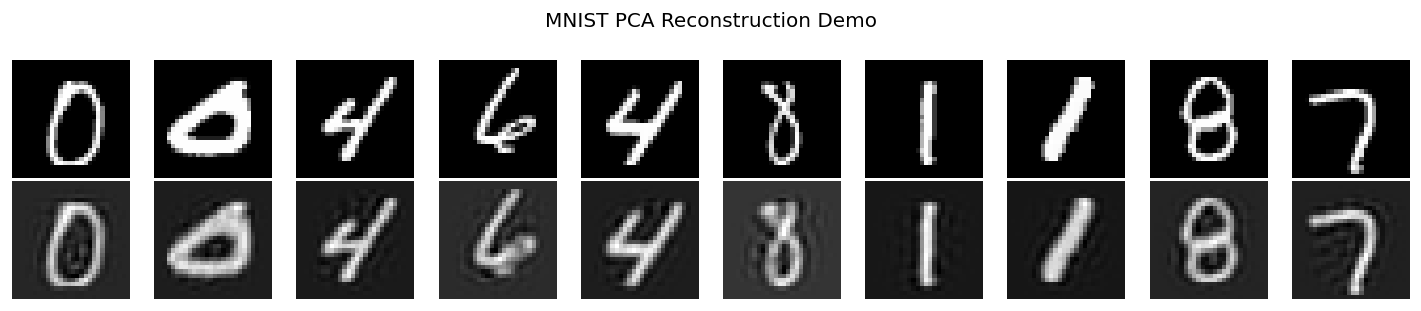

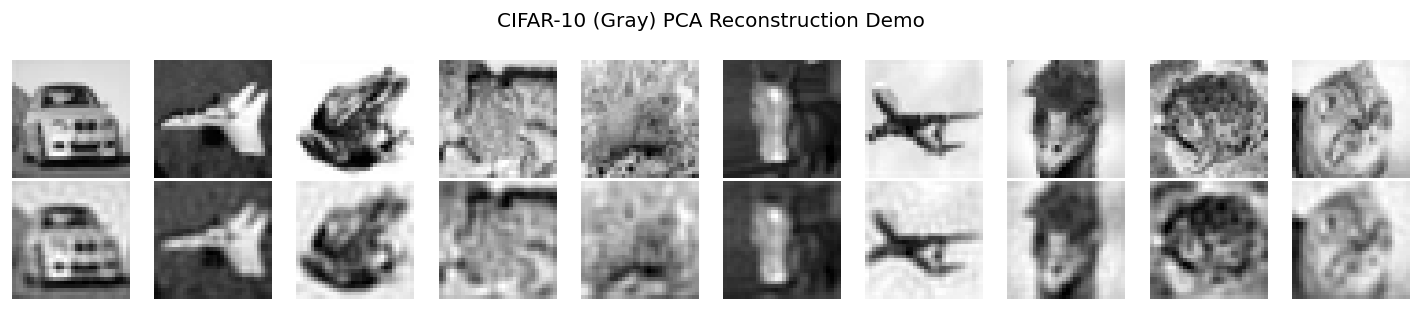

In [27]:
pca_demo_m = PCA(n_components=252)
Z_demo_m = pca_demo_m.fit_transform(X_mnist_scaled)
X_demo_m_scaled = pca_demo_m.inverse_transform(Z_demo_m)
X_demo_m = scaler_m.inverse_transform(X_demo_m_scaled)
idx_show = np.random.choice(len(X_demo_m), size=10, replace=False)
fig, axes = plt.subplots(2, 10, figsize=(12, 2.6))
for c, i in enumerate(idx_show):
    orig_i = scaler_m.inverse_transform(X_mnist_scaled[i:i+1])[0]
    axes[0, c].imshow(orig_i.reshape(img_h_m, img_w_m), cmap='gray'); axes[0, c].axis('off')
    axes[1, c].imshow(X_demo_m[i].reshape(img_h_m, img_w_m), cmap='gray'); axes[1, c].axis('off')
axes[0,0].set_ylabel('Orig'); axes[1,0].set_ylabel('k=50');
plt.suptitle('MNIST PCA Reconstruction Demo'); plt.tight_layout(); plt.show()

pca_demo_c = PCA(n_components=252)
Z_demo_c = pca_demo_c.fit_transform(X_cifar_scaled)
X_demo_c_scaled = pca_demo_c.inverse_transform(Z_demo_c)
X_demo_c = scaler_c.inverse_transform(X_demo_c_scaled)
idx_show = np.random.choice(len(X_demo_c), size=10, replace=False)
fig, axes = plt.subplots(2, 10, figsize=(12, 2.6))
for c, i in enumerate(idx_show):
    orig_i = scaler_c.inverse_transform(X_cifar_scaled[i:i+1])[0]
    axes[0, c].imshow(orig_i.reshape(img_h_c, img_w_c), cmap='gray'); axes[0, c].axis('off')
    axes[1, c].imshow(X_demo_c[i].reshape(img_h_c, img_w_c), cmap='gray'); axes[1, c].axis('off')
axes[0,0].set_ylabel('Orig'); axes[1,0].set_ylabel('k=128');
plt.suptitle('CIFAR-10 (Gray) PCA Reconstruction Demo'); plt.tight_layout(); plt.show()